In [1]:
import pymc3 as pm

import theano
import theano.tensor as tt
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Setting true function 1

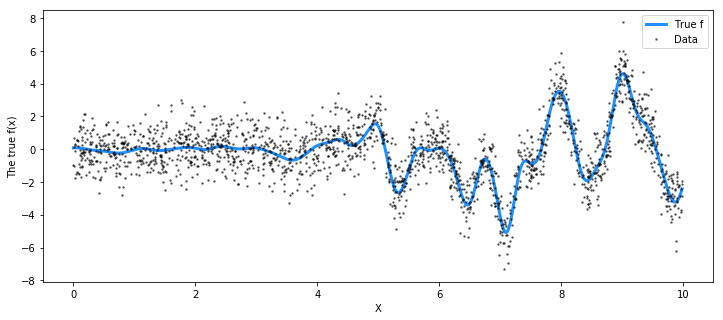

In [120]:
# set the seed
np.random.seed(1)

n = 2000 # The number of data points
X = 10*np.sort(np.random.rand(n))[:,None]

#Define the true covariance function and its parameters
def logistic(x, a, x0, c, d):
    # a is the slope, x0 is the location
    return d * pm.math.invlogit(a*(x - x0)) + c


a = 2.0
x0 = 5.0
c = 0.1
d = 2.0

cov_base = pm.gp.cov.ExpQuad(1, 0.2)
cov_func = pm.gp.cov.ScaledCov(1, scaling_func=logistic, args=(a,x0,c,d), cov_func=cov_base)
# period = 3
# cov_func = 50*pm.gp.cov.Cosine(1, period)
# ℓ_true = 1.0
# η_true = 3.0
# cov_func = η_true**2 * pm.gp.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true1 = np.random.multivariate_normal(mean_func(X).eval(),
                                       cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

# The observed data is the latent function plus a small amount of IID Gaussian noise
# The standard deviation of the noise is `sigma`
σ_true1 = 1
y1 = f_true1 + σ_true1 * np.random.randn(n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(X, f_true1, "dodgerblue", lw=3, label="True f");
ax.plot(X, y1, '.k', ms=3, alpha=0.5, label="Data");
ax.set_xlabel("X"); ax.set_ylabel("The true f(x)"); plt.legend();

# setting true function2

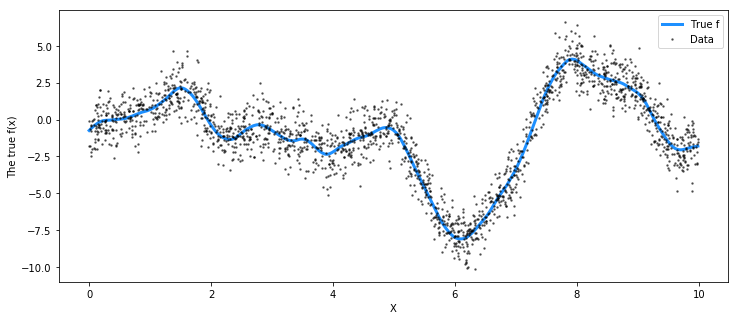

In [3]:
# set the seed
np.random.seed(1)

n = 2000 # The number of data points
X = 10*np.sort(np.random.rand(n))[:,None]

#Define the true covariance function and its parameters
# def logistic(x, a, x0, c, d):
#     # a is the slope, x0 is the location
#     return d * pm.math.invlogit(a*(x - x0)) + c


# a = 2.0
# x0 = 5.0
# c = 0.1
# d = 2.0

# cov_base = pm.gp.cov.ExpQuad(1, 0.2)
# cov_func = pm.gp.cov.ScaledCov(1, scaling_func=logistic, args=(a,x0,c,d), cov_func=cov_base)
# period = 3
# cov_func = 50*pm.gp.cov.Cosine(1, period)
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true**2 * pm.gp.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true2 = np.random.multivariate_normal(mean_func(X).eval(),
                                       cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

# The observed data is the latent function plus a small amount of IID Gaussian noise
# The standard deviation of the noise is `sigma`
σ_true2 = 1
y2 = f_true2 + σ_true2 * np.random.randn(n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(X, f_true2, "dodgerblue", lw=3, label="True f");
ax.plot(X, y2, '.k', ms=3, alpha=0.5, label="Data");
ax.set_xlabel("X"); ax.set_ylabel("The true f(x)"); plt.legend();

In [4]:
import time

# DTC Sparse Approximation - Kmeans inducing points

In [27]:
start = time.time()
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
#     period = 3
#     cov = 50*pm.gp.cov.Cosine(1, period)
    gp = pm.gp.MarginalSparse(cov_func=cov, approx="DTC")

    # initialize 20 inducing points with K-means
    # gp.util
    Xu = pm.gp.util.kmeans_inducing_points(20, X)

    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, Xu=Xu, y=y1, noise=σ)

    trace = pm.sample(1000)
    
X_new = np.linspace(-1, 11, 200)[:,None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred1 = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples1 = pm.sample_posterior_predictive(trace, vars=[f_pred1], samples=1000)
    
end = time.time()
print(end - start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, η, ℓ]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 3000/3000 [02:15<00:00, 22.14draws/s]
The acceptance probability does not match the target. It is 0.8855919577025052, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:39<00:00, 10.02it/s]


298.79271697998047


0.7430152893066406


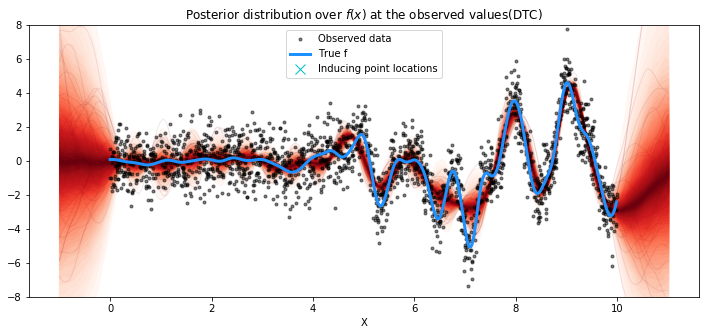

In [36]:
start = time.time()

# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples1["f_pred"], X_new);

# plot the data and the true latent function
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(Xu, 10*np.ones(Xu.shape[0]), "cx", ms=10, label="Inducing point locations")

# axis labels and title
plt.xlabel("X"); plt.ylim([-8,8]);
plt.title("Posterior distribution over $f(x)$ at the observed values(DTC)"); plt.legend();

end = time.time()
print(end - start)

# FITC Sparse Approximation - Kmeans inducing points

In [32]:
start = time.time()
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
#     period = 3
#     cov = 50*pm.gp.cov.Cosine(1, period)
    gp = pm.gp.MarginalSparse(cov_func=cov, approx="FITC")

    # initialize 20 inducing points with K-means
    # gp.util
    Xu = pm.gp.util.kmeans_inducing_points(20, X)

    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, Xu=Xu, y=y1, noise=σ)

    trace = pm.sample(1000)
    
X_new = np.linspace(-1, 11, 200)[:,None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred2 = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples2 = pm.sample_posterior_predictive(trace, vars=[f_pred2], samples=1000)
    
end = time.time()
print(end - start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, η, ℓ]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 3000/3000 [02:06<00:00, 20.81draws/s]
The acceptance probability does not match the target. It is 0.8824037786498006, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:39<00:00, 10.22it/s]


257.34149861335754


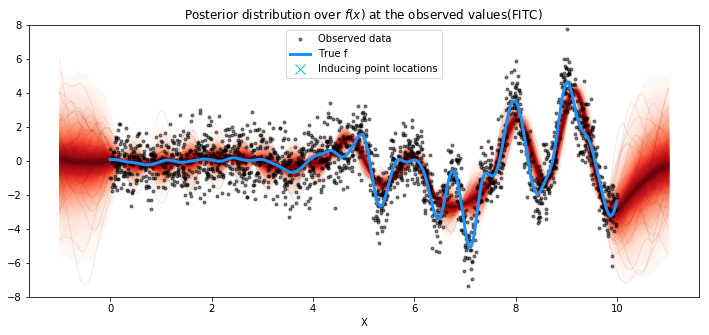

In [35]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples2["f_pred"], X_new);

# plot the data and the true latent function
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(Xu, 10*np.ones(Xu.shape[0]), "cx", ms=10, label="Inducing point locations")

# axis labels and title
plt.xlabel("X"); plt.ylim([-8,8]);
plt.title("Posterior distribution over $f(x)$ at the observed values(FITC)"); plt.legend();


# VFE Sparse Approximation - Kmeans inducing points

In [37]:
start = time.time()
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
#     period = 3
#     cov = 50*pm.gp.cov.Cosine(1, period)
    gp = pm.gp.MarginalSparse(cov_func=cov, approx="VFE")

    # initialize 20 inducing points with K-means
    # gp.util
    Xu = pm.gp.util.kmeans_inducing_points(20, X)

    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, Xu=Xu, y=y1, noise=σ)

    trace = pm.sample(1000)
    
X_new = np.linspace(-1, 11, 200)[:,None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred3 = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples3 = pm.sample_posterior_predictive(trace, vars=[f_pred3], samples=1000)
    
end = time.time()
print(end - start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, η, ℓ]
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:43<00:00, 10.38it/s]


389.7915954589844


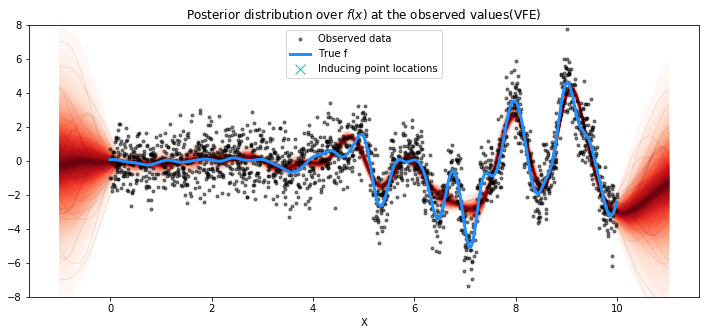

In [39]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples3["f_pred"], X_new);

# plot the data and the true latent function
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(Xu, 10*np.ones(Xu.shape[0]), "cx", ms=10, label="Inducing point locations")

# axis labels and title
plt.xlabel("X"); plt.ylim([-8,8]);
plt.title("Posterior distribution over $f(x)$ at the observed values(VFE)"); plt.legend();


# for  Function  2-DTC

In [5]:
start = time.time()
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
#     period = 3
#     cov = 50*pm.gp.cov.Cosine(1, period)
    gp = pm.gp.MarginalSparse(cov_func=cov, approx="DTC")

    # initialize 20 inducing points with K-means
    # gp.util
    Xu = pm.gp.util.kmeans_inducing_points(20, X)

    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, Xu=Xu, y=y2, noise=σ)

    trace = pm.sample(1000)
    
X_new = np.linspace(-1, 11, 200)[:,None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred4 = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples4 = pm.sample_posterior_predictive(trace, vars=[f_pred4], samples=1000)
    
end = time.time()
print(end - start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, η, ℓ]
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:43<00:00, 10.85it/s]


240.2610948085785


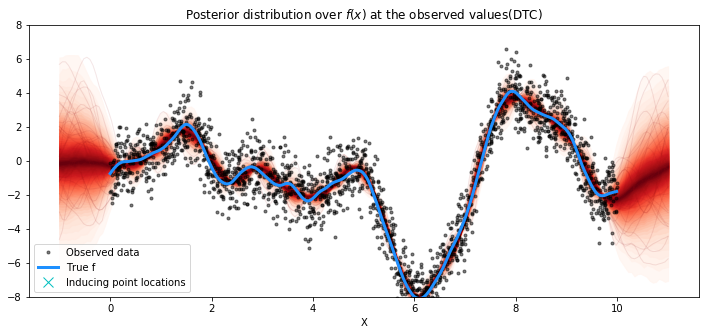

In [6]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples4["f_pred"], X_new);

# plot the data and the true latent function
plt.plot(X, y2, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.plot(X, f_true2, "dodgerblue", lw=3, label="True f");
plt.plot(Xu, 10*np.ones(Xu.shape[0]), "cx", ms=10, label="Inducing point locations")

# axis labels and title
plt.xlabel("X"); plt.ylim([-8,8]);
plt.title("Posterior distribution over $f(x)$ at the observed values(DTC)"); plt.legend();

# for Function 2-FITC

In [7]:
start = time.time()
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
#     period = 3
#     cov = 50*pm.gp.cov.Cosine(1, period)
    gp = pm.gp.MarginalSparse(cov_func=cov, approx="FITC")

    # initialize 20 inducing points with K-means
    # gp.util
    Xu = pm.gp.util.kmeans_inducing_points(20, X)

    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, Xu=Xu, y=y2, noise=σ)

    trace = pm.sample(1000)
    
X_new = np.linspace(-1, 11, 200)[:,None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred5 = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples5 = pm.sample_posterior_predictive(trace, vars=[f_pred5], samples=1000)
    
end = time.time()
print(end - start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, η, ℓ]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 3000/3000 [02:19<00:00, 21.46draws/s]
The acceptance probability does not match the target. It is 0.8918009268114383, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:48<00:00,  7.97it/s]


282.56008219718933


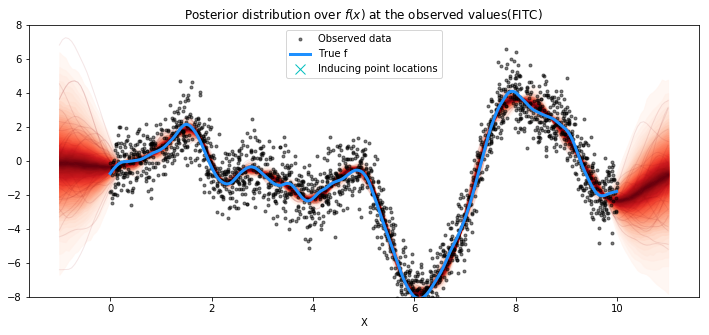

In [8]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples5["f_pred"], X_new);

# plot the data and the true latent function
plt.plot(X, y2, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.plot(X, f_true2, "dodgerblue", lw=3, label="True f");
plt.plot(Xu, 10*np.ones(Xu.shape[0]), "cx", ms=10, label="Inducing point locations")

# axis labels and title
plt.xlabel("X"); plt.ylim([-8,8]);
plt.title("Posterior distribution over $f(x)$ at the observed values(FITC)"); plt.legend();


# for function 2-VFE

In [9]:
start = time.time()
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
#     period = 3
#     cov = 50*pm.gp.cov.Cosine(1, period)
    gp = pm.gp.MarginalSparse(cov_func=cov, approx="VFE")

    # initialize 20 inducing points with K-means
    # gp.util
    Xu = pm.gp.util.kmeans_inducing_points(20, X)

    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, Xu=Xu, y=y2, noise=σ)

    trace = pm.sample(1000)
    
X_new = np.linspace(-1, 11, 200)[:,None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred6 = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples6 = pm.sample_posterior_predictive(trace, vars=[f_pred6], samples=1000)
    
end = time.time()
print(end - start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, η, ℓ]
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:54<00:00,  7.32it/s]


355.41146636009216


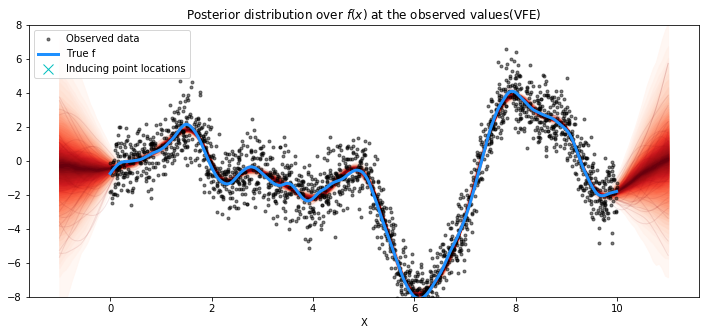

In [10]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples6["f_pred"], X_new);

# plot the data and the true latent function
plt.plot(X, y2, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.plot(X, f_true2, "dodgerblue", lw=3, label="True f");
plt.plot(Xu, 10*np.ones(Xu.shape[0]), "cx", ms=10, label="Inducing point locations")

# axis labels and title
plt.xlabel("X"); plt.ylim([-8,8]);
plt.title("Posterior distribution over $f(x)$ at the observed values(VFE)"); plt.legend();


 # Learning points DTC-function 1

In [12]:
start = time.time()
Xu_init = 10*np.random.rand(20)

with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.MarginalSparse(cov_func=cov, approx="DTC")

    # set flat prior for Xu
    Xu = pm.Flat("Xu", shape=20, testval=Xu_init)

    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, Xu=Xu[:, None], y=y1, noise=σ)

    mp = pm.find_MAP()
    
mu, var = gp.predict(X_new, point=mp, diag=True)
sd = np.sqrt(var)
end = time.time()
print(end - start)

C:\ProgramData\Anaconda3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -3,155.6, ||grad|| = 149.27: 100%|████████████████████████████████████████████| 581/581 [00:07<00:00, 74.35it/s]


19.6634624004364


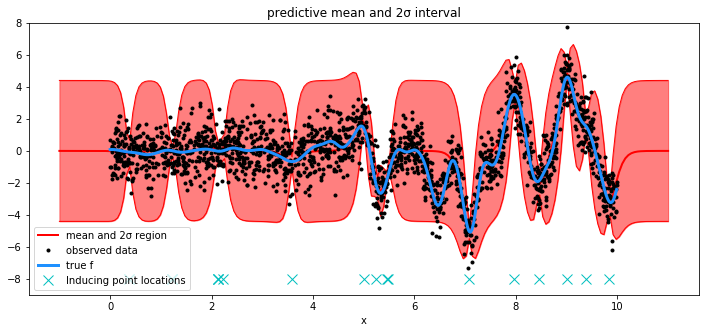

In [13]:

# draw plot
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot mean and 2σ intervals
plt.plot(X_new, mu, 'r', lw=2, label="mean and 2σ region");
plt.plot(X_new, mu + 2*sd, 'r', lw=1); plt.plot(X_new, mu - 2*sd, 'r', lw=1);
plt.fill_between(X_new.flatten(), mu - 2*sd, mu + 2*sd, color="r", alpha=0.5)

# plot original data and true function
plt.plot(X, y1, 'ok', ms=3, alpha=1.0, label="observed data");
plt.plot(X, f_true1, "dodgerblue", lw=3, label="true f");
Xu = mp["Xu"]
plt.plot(Xu, -8*np.ones(Xu.shape[0]), "cx", ms=10, label="Inducing point locations")

plt.xlabel("x"); plt.ylim([-9,8]);
plt.title("predictive mean and 2σ interval"); plt.legend();

# Learning points DTC-function 2

C:\ProgramData\Anaconda3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -2,919, ||grad|| = 2,394.3: 100%|█████████████████████████████████████████████| 151/151 [00:02<00:00, 69.55it/s]


11.387574434280396


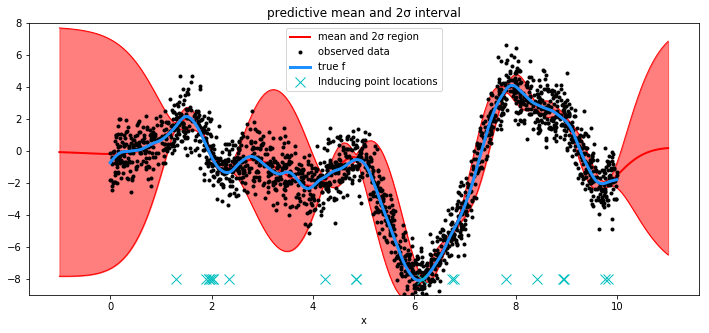

In [14]:
start = time.time()
Xu_init = 10*np.random.rand(20)

with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.MarginalSparse(cov_func=cov, approx="DTC")

    # set flat prior for Xu
    Xu = pm.Flat("Xu", shape=20, testval=Xu_init)

    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, Xu=Xu[:, None], y=y2, noise=σ)

    mp = pm.find_MAP()
    
mu, var = gp.predict(X_new, point=mp, diag=True)
sd = np.sqrt(var)
end = time.time()
print(end - start)

# draw plot
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot mean and 2σ intervals
plt.plot(X_new, mu, 'r', lw=2, label="mean and 2σ region");
plt.plot(X_new, mu + 2*sd, 'r', lw=1); plt.plot(X_new, mu - 2*sd, 'r', lw=1);
plt.fill_between(X_new.flatten(), mu - 2*sd, mu + 2*sd, color="r", alpha=0.5)

# plot original data and true function
plt.plot(X, y2, 'ok', ms=3, alpha=1.0, label="observed data");
plt.plot(X, f_true2, "dodgerblue", lw=3, label="true f");
Xu = mp["Xu"]
plt.plot(Xu, -8*np.ones(Xu.shape[0]), "cx", ms=10, label="Inducing point locations")

plt.xlabel("x"); plt.ylim([-9,8]);
plt.title("predictive mean and 2σ interval"); plt.legend();

# Learning points FITC function 1

C:\ProgramData\Anaconda3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -3,218.3, ||grad|| = 5.9438: 100%|████████████████████████████████████████████| 279/279 [00:03<00:00, 71.36it/s]


14.011563777923584


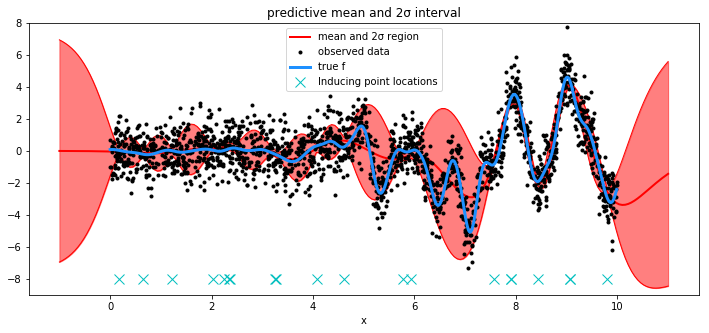

In [15]:
start = time.time()
Xu_init = 10*np.random.rand(20)

with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.MarginalSparse(cov_func=cov, approx="FITC")

    # set flat prior for Xu
    Xu = pm.Flat("Xu", shape=20, testval=Xu_init)

    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, Xu=Xu[:, None], y=y1, noise=σ)

    mp = pm.find_MAP()
    
mu, var = gp.predict(X_new, point=mp, diag=True)
sd = np.sqrt(var)
end = time.time()
print(end - start)

# draw plot
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot mean and 2σ intervals
plt.plot(X_new, mu, 'r', lw=2, label="mean and 2σ region");
plt.plot(X_new, mu + 2*sd, 'r', lw=1); plt.plot(X_new, mu - 2*sd, 'r', lw=1);
plt.fill_between(X_new.flatten(), mu - 2*sd, mu + 2*sd, color="r", alpha=0.5)

# plot original data and true function
plt.plot(X, y1, 'ok', ms=3, alpha=1.0, label="observed data");
plt.plot(X, f_true1, "dodgerblue", lw=3, label="true f");
Xu = mp["Xu"]
plt.plot(Xu, -8*np.ones(Xu.shape[0]), "cx", ms=10, label="Inducing point locations")

plt.xlabel("x"); plt.ylim([-9,8]);
plt.title("predictive mean and 2σ interval"); plt.legend();

# Learning points FITC function 2

C:\ProgramData\Anaconda3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -2,927.5, ||grad|| = 4.0165: 100%|████████████████████████████████████████████| 277/277 [00:03<00:00, 74.40it/s]


11.875271081924438


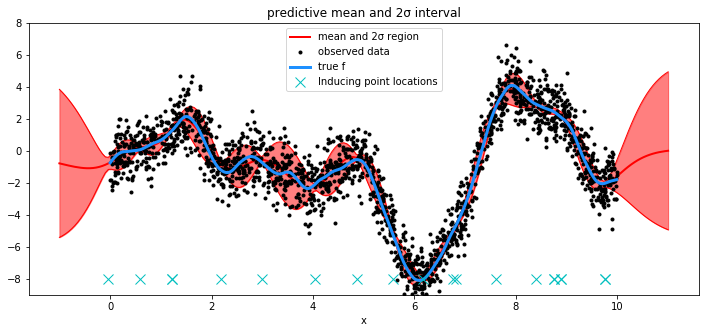

In [16]:
start = time.time()
Xu_init = 10*np.random.rand(20)

with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.MarginalSparse(cov_func=cov, approx="FITC")

    # set flat prior for Xu
    Xu = pm.Flat("Xu", shape=20, testval=Xu_init)

    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, Xu=Xu[:, None], y=y2, noise=σ)

    mp = pm.find_MAP()
    
mu, var = gp.predict(X_new, point=mp, diag=True)
sd = np.sqrt(var)
end = time.time()
print(end - start)

# draw plot
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot mean and 2σ intervals
plt.plot(X_new, mu, 'r', lw=2, label="mean and 2σ region");
plt.plot(X_new, mu + 2*sd, 'r', lw=1); plt.plot(X_new, mu - 2*sd, 'r', lw=1);
plt.fill_between(X_new.flatten(), mu - 2*sd, mu + 2*sd, color="r", alpha=0.5)

# plot original data and true function
plt.plot(X, y2, 'ok', ms=3, alpha=1.0, label="observed data");
plt.plot(X, f_true2, "dodgerblue", lw=3, label="true f");
Xu = mp["Xu"]
plt.plot(Xu, -8*np.ones(Xu.shape[0]), "cx", ms=10, label="Inducing point locations")

plt.xlabel("x"); plt.ylim([-9,8]);
plt.title("predictive mean and 2σ interval"); plt.legend();

# Learning points VFE function 1

C:\ProgramData\Anaconda3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -3,178.1, ||grad|| = 1.2802: 100%|██████████████████████████████████████████████| 91/91 [00:01<00:00, 75.72it/s]


9.610322952270508


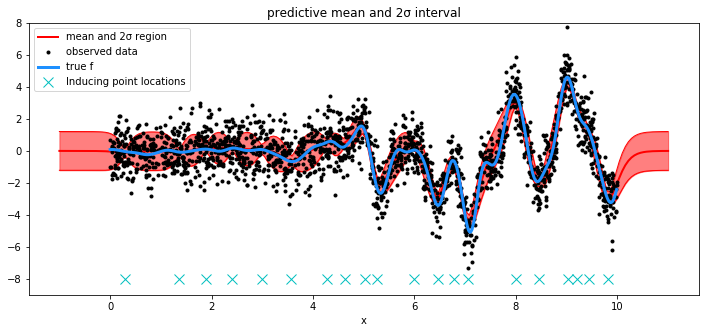

In [17]:
start = time.time()
Xu_init = 10*np.random.rand(20)

with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.MarginalSparse(cov_func=cov, approx="VFE")

    # set flat prior for Xu
    Xu = pm.Flat("Xu", shape=20, testval=Xu_init)

    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, Xu=Xu[:, None], y=y1, noise=σ)

    mp = pm.find_MAP()
    
mu, var = gp.predict(X_new, point=mp, diag=True)
sd = np.sqrt(var)
end = time.time()
print(end - start)

# draw plot
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot mean and 2σ intervals
plt.plot(X_new, mu, 'r', lw=2, label="mean and 2σ region");
plt.plot(X_new, mu + 2*sd, 'r', lw=1); plt.plot(X_new, mu - 2*sd, 'r', lw=1);
plt.fill_between(X_new.flatten(), mu - 2*sd, mu + 2*sd, color="r", alpha=0.5)

# plot original data and true function
plt.plot(X, y1, 'ok', ms=3, alpha=1.0, label="observed data");
plt.plot(X, f_true1, "dodgerblue", lw=3, label="true f");
Xu = mp["Xu"]
plt.plot(Xu, -8*np.ones(Xu.shape[0]), "cx", ms=10, label="Inducing point locations")

plt.xlabel("x"); plt.ylim([-9,8]);
plt.title("predictive mean and 2σ interval"); plt.legend();

# Learning points VFE function 2

C:\ProgramData\Anaconda3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -2,965.4, ||grad|| = 0.10038: 100%|█████████████████████████████████████████████| 49/49 [00:00<00:00, 78.11it/s]


8.800487756729126


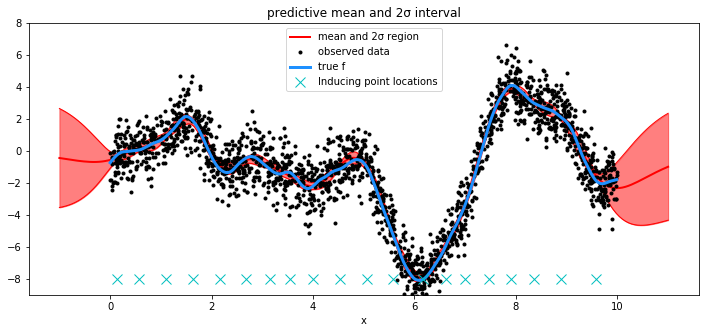

In [18]:
start = time.time()
Xu_init = 10*np.random.rand(20)

with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.MarginalSparse(cov_func=cov, approx="VFE")

    # set flat prior for Xu
    Xu = pm.Flat("Xu", shape=20, testval=Xu_init)

    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, Xu=Xu[:, None], y=y2, noise=σ)

    mp = pm.find_MAP()
    
mu, var = gp.predict(X_new, point=mp, diag=True)
sd = np.sqrt(var)
end = time.time()
print(end - start)

# draw plot
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot mean and 2σ intervals
plt.plot(X_new, mu, 'r', lw=2, label="mean and 2σ region");
plt.plot(X_new, mu + 2*sd, 'r', lw=1); plt.plot(X_new, mu - 2*sd, 'r', lw=1);
plt.fill_between(X_new.flatten(), mu - 2*sd, mu + 2*sd, color="r", alpha=0.5)

# plot original data and true function
plt.plot(X, y2, 'ok', ms=3, alpha=1.0, label="observed data");
plt.plot(X, f_true2, "dodgerblue", lw=3, label="true f");
Xu = mp["Xu"]
plt.plot(Xu, -8*np.ones(Xu.shape[0]), "cx", ms=10, label="Inducing point locations")

plt.xlabel("x"); plt.ylim([-9,8]);
plt.title("predictive mean and 2σ interval"); plt.legend();

# Function 1-DTC Randomly choose inducing points

In [39]:
start = time.time()
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
#     period = 3
#     cov = 50*pm.gp.cov.Cosine(1, period)
    gp = pm.gp.MarginalSparse(cov_func=cov, approx="DTC")

    # initialize 20 inducing points with K-means
    # gp.util
    Xu = np.random.choice(X.flatten(), 20).reshape(20,1)

    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, Xu=Xu, y=y1, noise=σ)

    trace = pm.sample(1000)
    
X_new = np.linspace(-1, 11, 200)[:,None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred7 = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples7 = pm.sample_posterior_predictive(trace, vars=[f_pred7], samples=1000)
    
end = time.time()
print(end - start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, η, ℓ]
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:37<00:00,  9.55it/s]


231.69597816467285


0.7470035552978516


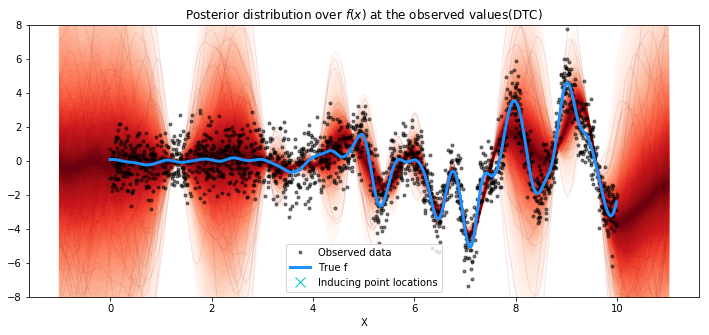

In [40]:
start = time.time()

# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples7["f_pred"], X_new);

# plot the data and the true latent function
plt.plot(X, y1, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.plot(X, f_true1, "dodgerblue", lw=3, label="True f");
plt.plot(Xu, 10*np.ones(Xu.shape[0]), "cx", ms=10, label="Inducing point locations")

# axis labels and title
plt.xlabel("X"); plt.ylim([-8,8]);
plt.title("Posterior distribution over $f(x)$ at the observed values(DTC)"); plt.legend();

end = time.time()
print(end - start)

# Function 1-FITC Randomly choose inducing points

In [41]:
start = time.time()
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
#     period = 3
#     cov = 50*pm.gp.cov.Cosine(1, period)
    gp = pm.gp.MarginalSparse(cov_func=cov, approx="FITC")

    # initialize 20 inducing points with K-means
    # gp.util
    Xu = np.random.choice(X.flatten(), 20).reshape(20,1)

    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, Xu=Xu, y=y1, noise=σ)

    trace = pm.sample(1000)
    
X_new = np.linspace(-1, 11, 200)[:,None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred8 = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples8 = pm.sample_posterior_predictive(trace, vars=[f_pred8], samples=1000)
    
end = time.time()
print(end - start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, η, ℓ]
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:50<00:00,  9.01it/s]


239.23284125328064


0.798863410949707


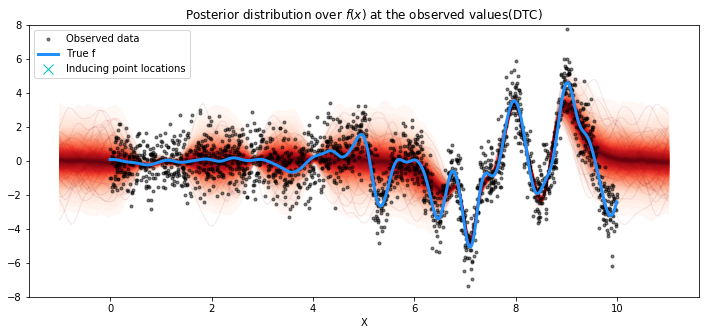

In [49]:
start = time.time()

# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples8["f_pred"], X_new);

# plot the data and the true latent function
plt.plot(X, y1, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.plot(X, f_true1, "dodgerblue", lw=3, label="True f");
plt.plot(Xu, 10*np.ones(Xu.shape[0]), "cx", ms=10, label="Inducing point locations")

# axis labels and title
plt.xlabel("X"); plt.ylim([-8,8]);
plt.title("Posterior distribution over $f(x)$ at the observed values(DTC)"); plt.legend();

end = time.time()
print(end - start)

# Function 1-VFE Randomly choose inducing points

In [50]:
start = time.time()
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
#     period = 3
#     cov = 50*pm.gp.cov.Cosine(1, period)
    gp = pm.gp.MarginalSparse(cov_func=cov, approx="VFE")

    # initialize 20 inducing points with K-means
    # gp.util
    Xu = np.random.choice(X.flatten(), 20).reshape(20,1)

    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, Xu=Xu, y=y1, noise=σ)

    trace = pm.sample(1000)
    
X_new = np.linspace(-1, 11, 200)[:,None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred9 = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples9 = pm.sample_posterior_predictive(trace, vars=[f_pred9], samples=1000)
    
end = time.time()
print(end - start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, η, ℓ]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 3000/3000 [02:31<00:00,  8.49draws/s]
The acceptance probability does not match the target. It is 0.892863097766036, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8843573111614651, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:48<00:00,  9.24it/s]


293.0341019630432


0.7250916957855225


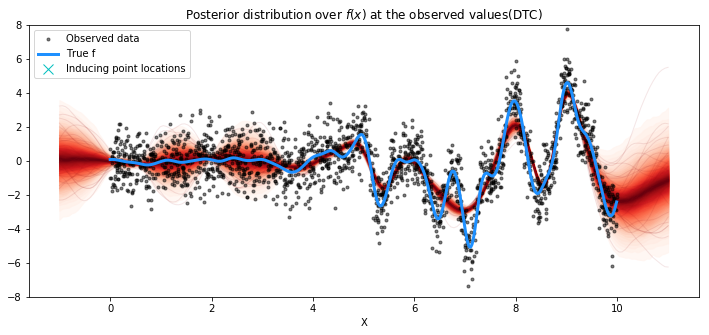

In [51]:
start = time.time()

# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples9["f_pred"], X_new);

# plot the data and the true latent function
plt.plot(X, y1, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.plot(X, f_true1, "dodgerblue", lw=3, label="True f");
plt.plot(Xu, 10*np.ones(Xu.shape[0]), "cx", ms=10, label="Inducing point locations")

# axis labels and title
plt.xlabel("X"); plt.ylim([-8,8]);
plt.title("Posterior distribution over $f(x)$ at the observed values(DTC)"); plt.legend();

end = time.time()
print(end - start)

# SoD Approximation of GP(Not Sparse)

In [117]:
nsod=100
idx = np.sort(np.random.choice(2000,nsod))
xsod = X[0:nsod]
ysod = y1[0:nsod]
for i in range(nsod):
    xsod[i] = X[idx[i]]
    ysod[i] = y1[idx[i]]



In [118]:
# A one dimensional column vector of inputs.
start = time.time()
with pm.Model() as model:
    # Specify the covariance function.
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)

    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Marginal(cov_func=cov)

    # Place a GP prior over the function f.
    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", X=xsod, y=ysod, noise=σ)
    
    mp = pm.find_MAP()

X_new = np.linspace(-1, 11, 200)[:,None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred10 = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples10 = pm.sample_posterior_predictive([mp], vars=[f_pred10], samples=1000)
    

end = time.time()
print(end - start)

C:\ProgramData\Anaconda3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -169.26, ||grad|| = 0.29111: 100%|█████████████████████████████████████████████| 25/25 [00:00<00:00, 144.89it/s]
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:40<00:00, 26.29it/s]


46.594512939453125


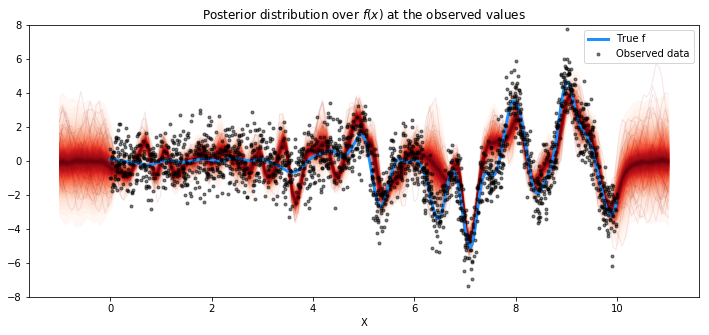

In [121]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples10["f_pred"], X_new);

# plot the data and the true latent function
plt.plot(X, f_true1, "dodgerblue", lw=3, label="True f");
plt.plot(X, y1, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("X"); plt.ylim([-8,8]);
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

# GP without sparse approximation

In [127]:
# A one dimensional column vector of inputs.

start = time.time()
with pm.Model() as model:
    # Specify the covariance function.
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)

    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Marginal(cov_func=cov_func)

    # Place a GP prior over the function f.
    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, y=y1, noise=σ)
    
    mp = pm.find_MAP()

    
X_new = np.linspace(-1, 11, 200)[:,None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred11 = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples11 = pm.sample_posterior_predictive([mp], vars=[f_pred11], samples=500)
end = time.time()
print(end - start)    




C:\ProgramData\Anaconda3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -2,931.6, ||grad|| = 0.17111: 100%|█████████████████████████████████████████████| 41/41 [02:33<00:00,  2.76s/it]
100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [10:17<00:00,  1.17s/it]


825.7704365253448


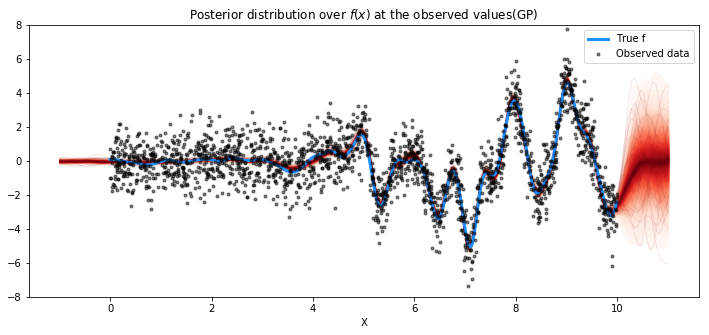

In [128]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples11["f_pred"], X_new);

# plot the data and the true latent function
plt.plot(X, f_true1, "dodgerblue", lw=3, label="True f");
plt.plot(X, y1, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("X"); plt.ylim([-8,8]);
plt.title("Posterior distribution over $f(x)$ at the observed values(GP)"); plt.legend();

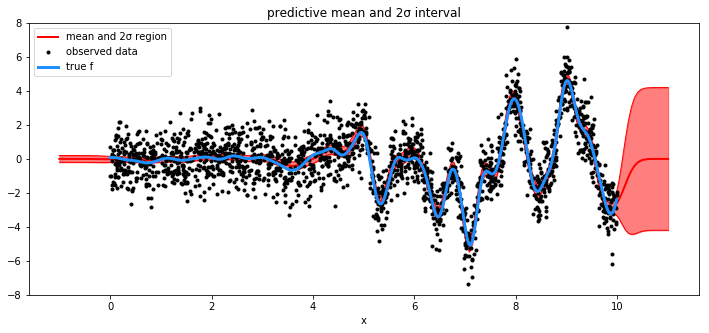

In [129]:
# predict
mu, var = gp.predict(X_new, point=mp, diag=True)
sd = np.sqrt(var)

# draw plot
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot mean and 2σ intervals
plt.plot(X_new, mu, 'r', lw=2, label="mean and 2σ region");
plt.plot(X_new, mu + 2*sd, 'r', lw=1); plt.plot(X_new, mu - 2*sd, 'r', lw=1);
plt.fill_between(X_new.flatten(), mu - 2*sd, mu + 2*sd, color="r", alpha=0.5)

# plot original data and true function
plt.plot(X, y1, 'ok', ms=3, alpha=1.0, label="observed data");
plt.plot(X, f_true1, "dodgerblue", lw=3, label="true f");

plt.xlabel("x"); plt.ylim([-8,8]);
plt.title("predictive mean and 2σ interval"); plt.legend();

In [16]:
x1, x2 = np.meshgrid(np.linspace(0,1,10), np.arange(1,4))
X2 = np.concatenate((x1.reshape((30,1)), x2.reshape((30,1))), axis=1)
X = np.arange(-5, 5, 0.2).reshape(-1, 1)
X.shape

(50, 1)

In [8]:
import numpy, scipy.io

# arr = numpy.arange(10)
# arr = arr.reshape((3, 3))  # 2d array of 3x3

scipy.io.savemat('K:/6thSem/CS698X/Project/arrdata.mat', mdict={'arr': y})